In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
from sklearn.metrics import *

# Preparing data
Using data from [Hugging face](https://huggingface.co/datasets/tweets_hate_speech_detection)

Working reference by Paper
* [Journal 1](https://arxiv.org/pdf/1706.00188v1.pdf)
* [Journal 2](https://dl.acm.org/doi/pdf/10.1145/3447535.3462484)
* [Journal 3](https://arxiv.org/pdf/1803.08977v1.pdf)
* [Journal 4](https://arxiv.org/pdf/2104.10513v1.pdf)


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

## load data to DataFrame

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [ ]:
def load_datasets(data,target_data):
  result_dict={}
  data_train=data[target_data]
  texts=[]
  label=[]
  for text,labels in zip(data_train['tweet'],data_train['label']):
    texts.append(text)
    label.append(labels)
  result_dict={
    "tweet":texts,
    "labels":label
  }
  return result_dict

In [ ]:
train_df_datasets=load_datasets(data=dataset,target_data='train')

In [ ]:
data_train_df=pd.DataFrame(train_df_datasets)

In [ ]:
data_train_df

,tweet,labels
0,@user when a father is dysfunctional and is so...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
...,...,...
31957,ate @user isz that youuu?ðððððð...,0
31958,to see nina turner on the airwaves trying to w...,0
31959,listening to sad songs on a monday morning otw...,0
31960,"@user #sikh #temple vandalised in in #calgary,...",1


# EDA

## transform label

Tranform label from https://huggingface.co/datasets/tweets_hate_speech_detection
<br>
* label : 1 - it is a hate speech
* 0 - not a hate speech.


In [ ]:
def transform_label(rating):
  if rating==0:
    return "not_hate"
  if rating==1:
    return "hate"

In [ ]:
data_train_df['sentiment']=data_train_df['labels'].apply(transform_label)

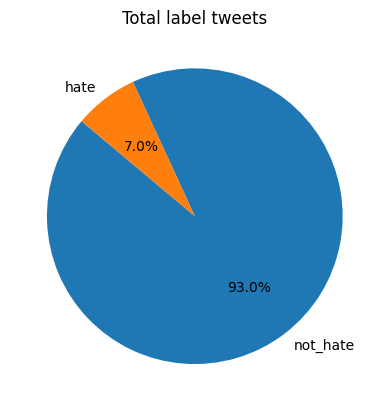

In [ ]:
plt.pie(x=data_train_df['sentiment'].value_counts(),labels=data_train_df['sentiment'].unique(),autopct='%1.1f%%',startangle=140)
plt.title("Total label tweets")
plt.show()

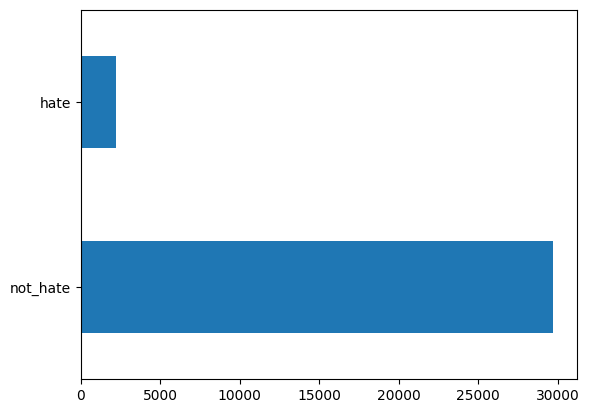

In [ ]:
data_train_df.sentiment.value_counts().plot.barh();

`Looks like`
* 0 label is not hate
* 1 labels is hate speech
* not hate aka 0 is most common label than label 1 (hate speech)



## Wordlcoud

In [ ]:
import cv2
from wordcloud import WordCloud

In [ ]:
!wget https://raw.githubusercontent.com/ackermanjayjay/transer-news-sentiment/main/cloud.jpg

--2023-10-01 10:21:57--  https://raw.githubusercontent.com/ackermanjayjay/transer-news-sentiment/main/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg’

cloud.jpg           100%[===================>]  33.59K  --.-KB/s    in 0.01s   

2023-10-01 10:21:58 (3.02 MB/s) - ‘cloud.jpg’ saved [34396/34396]



In [ ]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

def word_cloud(data,clean_columns_data,columnsTargetLabel,label):

  data_target = data[data[columnsTargetLabel] == label]
  string_label = []

  for t in data_target[clean_columns_data]:
    string_label .append(t)

  string_label = pd.Series(string_label).str.cat(sep=' ')

  wordcloud = WordCloud(width=1600, height=800, margin=10,
                        background_color='white', colormap='Dark2',
                        max_font_size=200, min_font_size=25,
                        mask=cloud_mask, contour_width=10, contour_color='firebrick',
                        max_words=100).generate(string_label)
  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(label)
  plt.show()

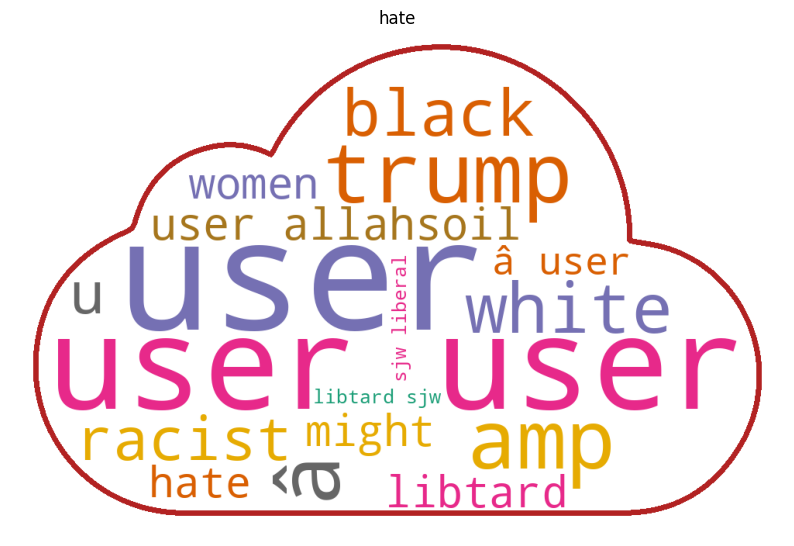

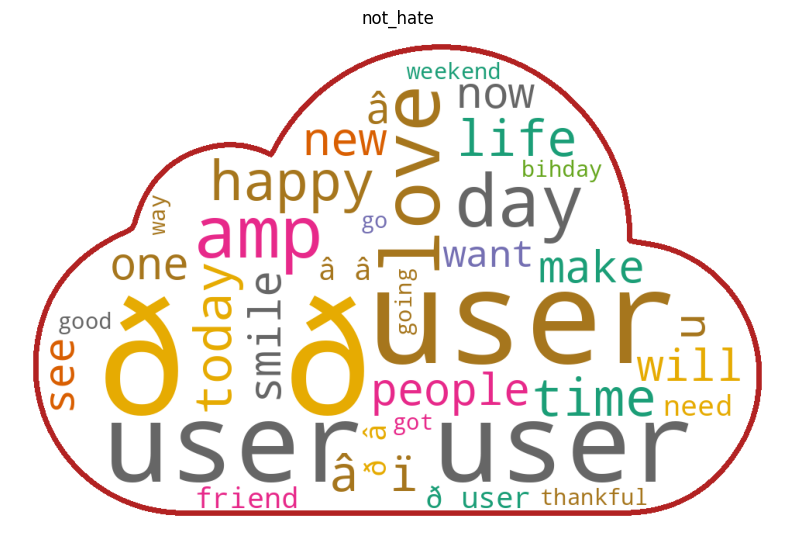

In [ ]:
import numpy as np
label_string=[]
for label in data_train_df["sentiment"]:
    label_string.append(label)
for label in np.unique(label_string):
            word_cloud(data=data_train_df,
            clean_columns_data="tweet",
            columnsTargetLabel="sentiment",
            label=(label))

## Vector words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
bag_of_words=CountVectorizer()
corpus=data_train_df['tweet']
bag_of_words_tweets=bag_of_words.fit_transform(corpus).toarray()

In [ ]:
data_bag_of_words=pd.DataFrame({
    'features':bag_of_words.get_feature_names_out(),
    'scores_freq':bag_of_words_tweets.sum(axis=0)
})
top_ten_most_words_bag_of_words=data_bag_of_words.sort_values(by='scores_freq',ascending=False).head(10)

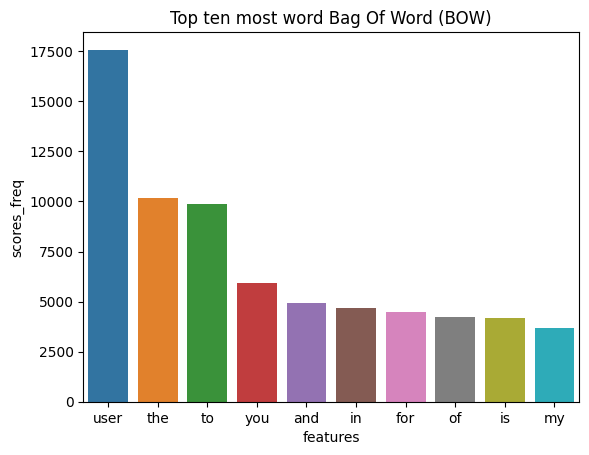

In [ ]:
sns.barplot(data=top_ten_most_words_bag_of_words,x='features',y='scores_freq')
plt.title('Top ten most word Bag Of Word (BOW)')
plt.show()

the ten words that appear the most are stopwords
* the
* to
* you
* and
* in
* for
* of
* is
* my

And must doing preprocessing
* Casefolding
* Remove stopwords
* Remove punctuation and number
* Stemming

## Preprocessing

In [ ]:
def caseFolding(text):
  text=text.lower()
  return text


import re
def punc_removal(text):
  text=re.sub(r"[^a-zA-Z]"," ",text)
  return text

# import StemmerFactory class

# create stemmer
import nltk
from nltk import *
stemmer = PorterStemmer()
def stemsWords(text):
  text=stemmer.stem(text)
  return text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')
stp=stopwords.words('english')

def flatten(l):
    """
    Same as
    flat_list = []
    for sublist in l:
    for item in sublist:
        flat_list.append(item)

    Example =[[1,2,3,4,5]] - > [1,2,3,4,5]
    """
    return " ".join([item for sublist in l for item in sublist])

def remove_stop_words(text):
  stopWords_add=['us','like']
  stopWords_combine=stopWords_add+stp
  clean_words = []
  text=text.split()
  perulangan_text=[word for word in text if word not in stopWords_combine]
  clean_words.append(perulangan_text)
  return flatten(clean_words)

def preprocessing_text(text):
  text=caseFolding(text)
  text=punc_removal(text)
  text=remove_stop_words(text)
  text=stemsWords(text)
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_train_df['clean_text_tweet']=data_train_df['tweet'].apply(preprocessing_text)

In [ ]:
bag_of_words_clean_tweets=CountVectorizer()
corpus_tweets_clean=data_train_df['clean_text_tweet']
bag_of_words_tweetsClean=bag_of_words_clean_tweets.fit_transform(corpus_tweets_clean).toarray()

In [ ]:
data_bag_of_words_tweetsClean=pd.DataFrame({
    'features':bag_of_words_clean_tweets.get_feature_names_out(),
    'scores_freq':bag_of_words_tweetsClean.sum(axis=0)
})
top_ten_most_words_bag_of_words_cleanTweets=data_bag_of_words_tweetsClean.sort_values(by='scores_freq',ascending=False).head(10)

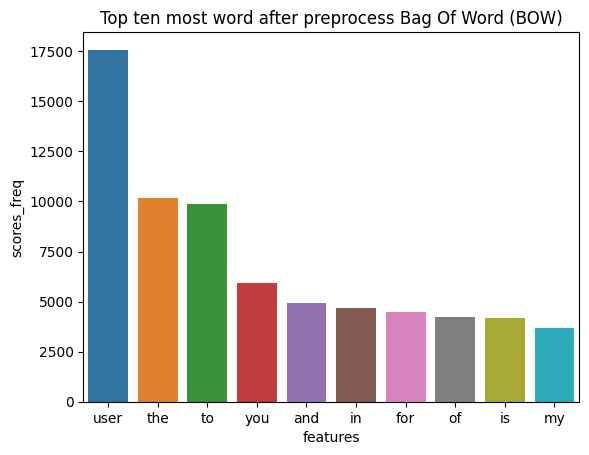

In [ ]:
sns.barplot(data=top_ten_most_words_bag_of_words,x='features',y='scores_freq')
plt.title('Top ten most word after preprocess Bag Of Word (BOW)')
plt.show()

most word is `user`

## Wordcloud after preprocessing

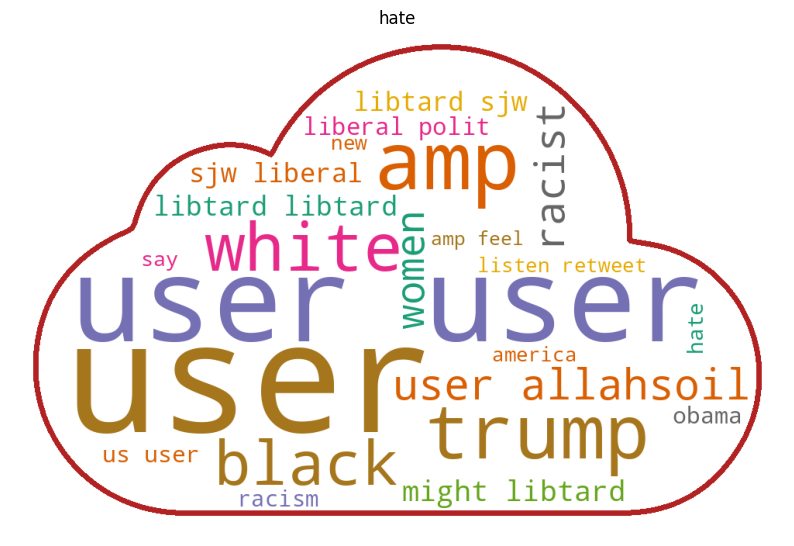

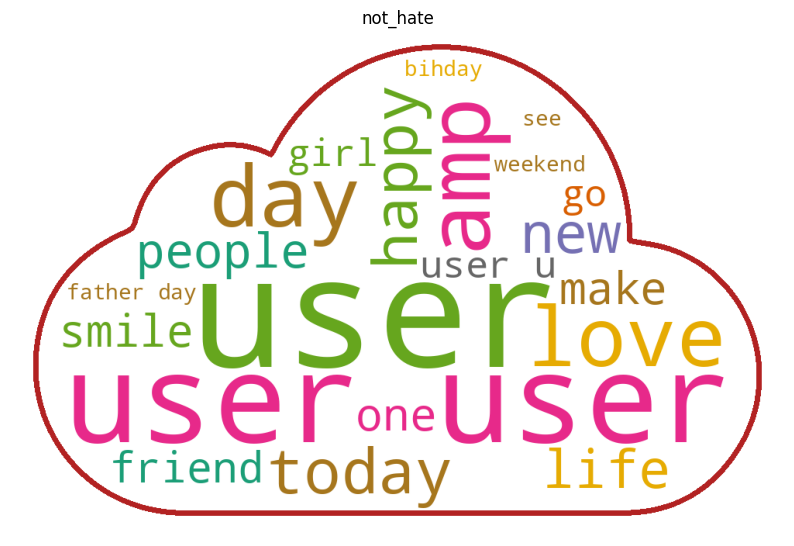

In [ ]:
import numpy as np
label_string=[]
for label in data_train_df["sentiment"]:
    label_string.append(label)
for label in np.unique(label_string):
            word_cloud(data=data_train_df,
            clean_columns_data="clean_text_tweet",
            columnsTargetLabel="sentiment",
            label=(label))

## Total lines

In [ ]:
data_train_df['total_lines_before_preprocess']=data_train_df['tweet'].apply(lambda n : len(n.split()))

In [ ]:
data_train_df

,tweet,labels,sentiment,clean_text_tweet,total_lines_before_preprocess
0,@user when a father is dysfunctional and is so...,0,not_hate,user father dysfunctional selfish drags kids d...,18
1,@user @user thanks for #lyft credit i can't us...,0,not_hate,user user thanks lyft credit use cause offer w...,19
2,bihday your majesty,0,not_hate,bihday majesti,3
3,#model i love u take with u all the time in ...,0,not_hate,model love u take u time ur,14
4,factsguide: society now #motivation,0,not_hate,factsguide society motiv,4
...,...,...,...,...,...
31957,ate @user isz that youuu?ðððððð...,0,not_hate,ate user isz youuu,5
31958,to see nina turner on the airwaves trying to w...,0,not_hate,see nina turner airwaves trying wrap mantle ge...,23
31959,listening to sad songs on a monday morning otw...,0,not_hate,listening sad songs monday morning otw work sad,13
31960,"@user #sikh #temple vandalised in in #calgary,...",1,hate,user sikh temple vandalised calgary wso condem...,10


In [ ]:
data_train_df['tweet'][0]

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

Check distribution length tweets

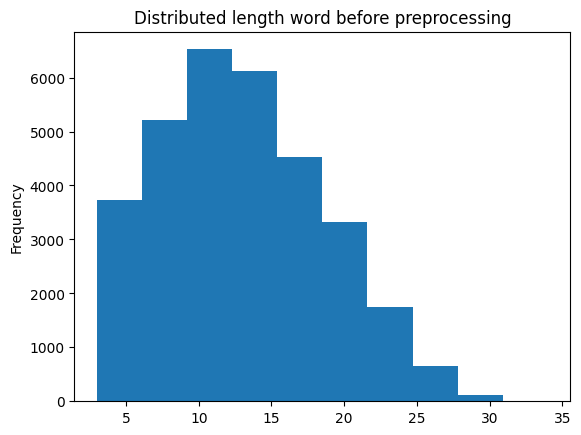

In [ ]:
data_train_df['total_lines_before_preprocess'].plot.hist();
plt.title("Distributed length word before preprocessing")
plt.show()

Okay, looks like most of the tweets are around 5 to 25 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

## total lines after preprocessing

In [ ]:
data_train_df['total_lines_after_preprocess']=data_train_df['clean_text_tweet'].apply(lambda n : len(n.split()))

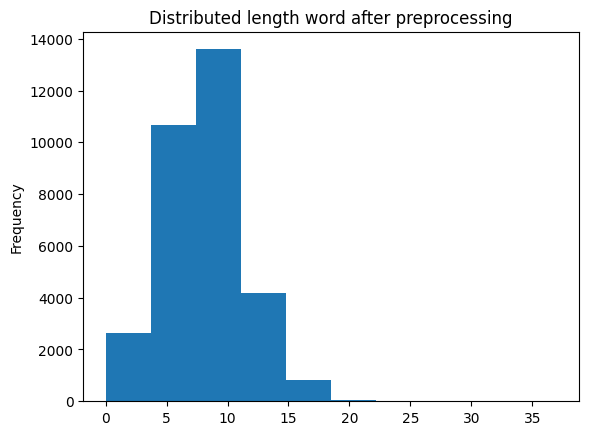

In [ ]:
data_train_df['total_lines_after_preprocess'].plot.hist();
plt.title("Distributed length word after preprocessing")
plt.show()

there is a change there may be a word that is deleted, namely the conjunction tweets are around 5 to 10 sentences in length.


# Baseline model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## after preprocessing

In [ ]:
X_korpus_preprocessing=data_train_df['clean_text_tweet']
y_label=data_train_df['labels']

In [ ]:
from sklearn.model_selection import train_test_split
X_train_preprocessing,  X_test_preprocessing, y_train_preprocessing, y_test_preprocessing = train_test_split(X_korpus_preprocessing, y_label, test_size=0.1, random_state=42)

In [ ]:
print(f'Total data train: {len(X_train_preprocessing)}')
print(f'Total data test: {len(X_test_preprocessing)}')

Total data train: 28765
Total data test: 3197


### Naives bayes

In [ ]:
model_naivesBayes_preprocess_tfidf=Pipeline([
    ('count vector',TfidfVectorizer()),
    ('Naives bayes',MultinomialNB())
])

In [ ]:
model_naivesBayes_preprocess_tfidf.fit(X_train_preprocessing,y_train_preprocessing)

Pipeline(steps=[('count vector', TfidfVectorizer()),
                ('Naives bayes', MultinomialNB())])

#### Evaluation

In [ ]:
predict_naives_bayes_preprocess_tfidf=model_naivesBayes_preprocess_tfidf.predict(X_test_preprocessing)

In [ ]:
predict_naives_bayes_preprocess_tfidf

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
result_nb_tfidf_preprocess=calculate_results(y_test_preprocessing,predict_naives_bayes_preprocess_tfidf)

In [ ]:
result_nb_tfidf_preprocess

{'accuracy': 94.24460431654677,
 'precision': 0.9457888234866653,
 'recall': 0.9424460431654677,
 'f1': 0.9214267163792637}

In [ ]:
wrong_predict_NB_=(y_test_preprocessing!=predict_naives_bayes_preprocess_tfidf).sum()
correct_predict_NB_=(y_test_preprocessing==predict_naives_bayes_preprocess_tfidf).sum()
predict_hate_label=(predict_naives_bayes_preprocess_tfidf==0).sum()
predict_not_hate_label=(predict_naives_bayes_preprocess_tfidf==1).sum()
labels_true_hate_speech=(y_test_preprocessing==0).sum()
label_true_not_hate=(y_test_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_preprocessing,y_pred=predict_naives_bayes_preprocess_tfidf))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3168
Total predict not hate label : 29
Wrong prediction: 184
Correct prediction: 3013

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2984
           1       1.00      0.14      0.24       213

    accuracy                           0.94      3197
   macro avg       0.97      0.57      0.60      3197
weighted avg       0.95      0.94      0.92      3197



In [ ]:
# code from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
result_nb_tfidf_preprocess=calculate_results(y_true=y_test_preprocessing,y_pred=predict_naives_bayes_preprocess_tfidf)
result_nb_tfidf_preprocess

{'accuracy': 94.24460431654677,
 'precision': 0.9457888234866653,
 'recall': 0.9424460431654677,
 'f1': 0.9214267163792637}

### KNN

In [ ]:
model_knn_tfidf_preprocessing=Pipeline([
    ('TFIDF',TfidfVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
model_knn_tfidf_preprocessing=Pipeline([
    ('TFIDF',TfidfVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
model_knn_tfidf_preprocessing.fit(X_train_preprocessing,y_train_preprocessing)

Pipeline(steps=[('TFIDF', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [ ]:
predict_knn_tfidf=model_knn_tfidf_preprocessing.predict(X_test_preprocessing)

In [ ]:
predict_knn_tfidf[:5]

array([0, 0, 0, 0, 0])

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
result_knn_tfidf_preprocess=calculate_results(y_test_preprocessing,predict_knn_tfidf)
result_knn_tfidf_preprocess

{'accuracy': 95.0578667500782,
 'precision': 0.9472683962387102,
 'recall': 0.950578667500782,
 'f1': 0.9390489244109381}

In [ ]:
wrong_predict_knn_=(y_test_preprocessing!=predict_knn_tfidf).sum()
correct_predict_knn_=(y_test_preprocessing==predict_knn_tfidf).sum()
predict_hate_label=(predict_knn_tfidf==0).sum()
predict_not_hate_label=(predict_knn_tfidf==1).sum()
labels_true_hate_speech=(y_test_preprocessing==0).sum()
label_true_not_hate=(y_test_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_preprocessing,y_pred=predict_knn_tfidf))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3124
Total predict not hate label : 73
Wrong prediction: 158
Correct prediction: 3039

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2984
           1       0.88      0.30      0.45       213

    accuracy                           0.95      3197
   macro avg       0.91      0.65      0.71      3197
weighted avg       0.95      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [ ]:
pd.DataFrame(classification_report(y_true=y_test_preprocessing,y_pred=predict_knn_tfidf,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.952305,0.876712,0.950579,0.914509,0.947268
recall,0.996984,0.300469,0.950579,0.648727,0.950579
f1-score,0.974132,0.447552,0.950579,0.710842,0.939049
support,2984.000000,213.000000,0.950579,3197.000000,3197.000000


# Bag of Words

## after preprocessing

In [ ]:
print(f'Total data train: {len(X_train_preprocessing)}')
print(f'Total data test: {len(X_test_preprocessing)}')

Total data train: 28765
Total data test: 3197


### Naives bayes

In [ ]:
model_naivesBayes_preprocessing_bagOfWords=Pipeline([
    ('count vector',CountVectorizer()),
    ('Naives bayes',MultinomialNB())
])

In [ ]:
model_naivesBayes_preprocessing_bagOfWords.fit(X_train_preprocessing,y_train_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('Naives bayes', MultinomialNB())])

#### Evaluation

In [ ]:
predict_naives_bayes_preprocessing_bagOfWords=model_naivesBayes_preprocessing_bagOfWords.predict(X_test_preprocessing)

In [ ]:
result_nb_after_preprocessing_bagOfWord=calculate_results(y_test_before_preprocessing,predict_naives_bayes_preprocessing_bagOfWords)

In [ ]:
result_nb_after_preprocessing_bagOfWord

{'accuracy': 96.0900844541758,
 'precision': 0.957829080792026,
 'recall': 0.960900844541758,
 'f1': 0.9560251561480948}

In [ ]:
wrong_predict_NB_=(y_test_preprocessing!=predict_naives_bayes_preprocessing_bagOfWords).sum()
correct_predict_NB_=(y_test_preprocessing==predict_naives_bayes_preprocessing_bagOfWords).sum()
predict_hate_label=(predict_naives_bayes_preprocessing_bagOfWords==0).sum()
predict_not_hate_label=(predict_naives_bayes_preprocessing_bagOfWords==1).sum()
labels_true_hate_speech=(y_test_preprocessing==0).sum()
label_true_not_hate=(y_test_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_preprocessing,y_pred=predict_naives_bayes_preprocessing_bagOfWords))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3073
Total predict not hate label : 124
Wrong prediction: 125
Correct prediction: 3072

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2984
           1       0.85      0.50      0.63       213

    accuracy                           0.96      3197
   macro avg       0.91      0.75      0.80      3197
weighted avg       0.96      0.96      0.96      3197



### KNN

In [ ]:
model_knn_preprocessing_bagOfWords=Pipeline([
    ('count vector',CountVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
model_knn_preprocessing_bagOfWords.fit(X_train_preprocessing,y_train_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [ ]:
classes_knn_preprocessing_bagOfWords=model_knn_preprocessing_bagOfWords['KNN'].classes_
classes_knn_preprocessing_bagOfWords

array([0, 1])

In [ ]:
predict_knn_after_preprocess_bagOfWords=model_knn_preprocessing_bagOfWords.predict(X_test_preprocessing)

In [ ]:
predict_knn_after_preprocess_bagOfWords[:5]

array([0, 0, 0, 0, 0])

In [ ]:
result_knn_after_preprocessing_bagOfWord=calculate_results(y_test_preprocessing,predict_knn_after_preprocess_bagOfWords)
result_knn_after_preprocessing_bagOfWord

{'accuracy': 94.87019080387864,
 'precision': 0.9453100603360005,
 'recall': 0.9487019080387864,
 'f1': 0.9356676969681968}

In [ ]:
tn_knn_preprocessing_bagOfWords, fp_knn_preprocessing_bagOfWords, fn_knn_preprocessing_bagOfWords, tp_knn_preprocessing_bagOfWords = confusion_matrix(y_test_preprocessing,predict_knn_after_preprocess_bagOfWords).ravel()

In [ ]:
wrong_predict_knn_=(y_test_preprocessing!=predict_knn_after_preprocess_bagOfWords).sum()
correct_predict_knn_=(y_test_preprocessing==predict_knn_after_preprocess_bagOfWords).sum()
predict_hate_label=(predict_knn_after_preprocess_bagOfWords==0).sum()
predict_not_hate_label=(predict_knn_after_preprocess_bagOfWords==1).sum()
labels_true_hate_speech=(y_test_preprocessing==0).sum()
label_true_not_hate=(y_test_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_preprocessing,y_pred=predict_knn_after_preprocess_bagOfWords))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3132
Total predict not hate label : 65
Wrong prediction: 164
Correct prediction: 3033

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2984
           1       0.88      0.27      0.41       213

    accuracy                           0.95      3197
   macro avg       0.91      0.63      0.69      3197
weighted avg       0.95      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [ ]:
pd.DataFrame(classification_report(y_true=y_test_preprocessing,y_pred=predict_knn_after_preprocess_bagOfWords,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.950192,0.876923,0.948702,0.913557,0.945310
recall,0.997319,0.267606,0.948702,0.632462,0.948702
f1-score,0.973185,0.410072,0.948702,0.691629,0.935668
support,2984.000000,213.000000,0.948702,3197.000000,3197.000000


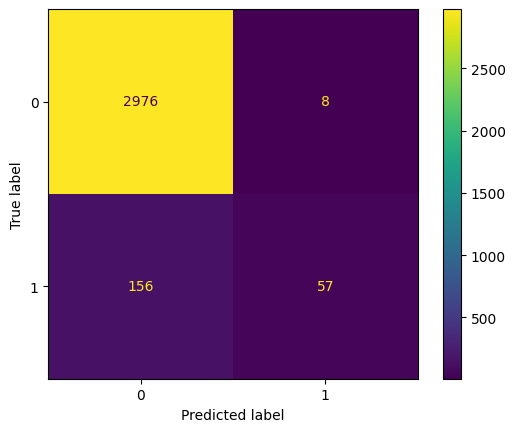

In [ ]:
cm_knn = confusion_matrix(y_test_preprocessing, predict_knn_after_preprocess_bagOfWords, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=classes_)
disp.plot()
plt.show()

## before preprocessing

In [ ]:
X_korpus=data_train_df['tweet']
y_label=data_train_df['labels']

In [ ]:
from sklearn.model_selection import train_test_split
X_train_before_preprocessing, X_test_before_preprocessing, y_train_before_preprocessing, y_test_before_preprocessing = train_test_split(X_korpus, y_label, test_size=0.1, random_state=42)

In [ ]:
print(f'Total data train: {len(X_train_before_preprocessing)}')
print(f'Total data test: {len(X_test_before_preprocessing)}')

Total data train: 28765
Total data test: 3197


### Naives bayes

In [ ]:
model_naivesBayes_before_preprocessing_bagOfWords=Pipeline([
    ('count vector',CountVectorizer()),
    ('Naives bayes',MultinomialNB())
])

In [ ]:
model_naivesBayes_before_preprocessing_bagOfWords.fit(X_train_before_preprocessing,y_train_before_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('Naives bayes', MultinomialNB())])

#### Evaluation

In [ ]:
predict_naives_bayes_before_preprocessing_bagOfWords=model_naivesBayes_before_preprocessing_bagOfWords.predict(X_test_before_preprocessing)

In [ ]:
result_nb_before_preprocessing_bagOfWord=calculate_results(y_test_before_preprocessing,predict_naives_bayes_before_preprocessing_bagOfWords)

In [ ]:
result_nb_before_preprocessing_bagOfWord

{'accuracy': 95.62089458867689,
 'precision': 0.9529883142532025,
 'recall': 0.9562089458867689,
 'f1': 0.9486190632848388}

In [ ]:
correct_predict_NB_=(y_test_before_preprocessing==model_naivesBayes_before_preprocessing_bagOfWords).sum()
predict_hate_label=(predict_naives_bayes_before_preprocessing_bagOfWords==0).sum()
predict_not_hate_label=(predict_naives_bayes_before_preprocessing_bagOfWords==1).sum()
labels_true_hate_speech=(y_test_before_preprocessing==0).sum()
label_true_not_hate=(y_test_before_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_naives_bayes_before_preprocessing_bagOfWords))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3098
Total predict not hate label : 99
Wrong prediction: 125
Correct prediction: 0

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2984
           1       0.87      0.40      0.55       213

    accuracy                           0.96      3197
   macro avg       0.91      0.70      0.76      3197
weighted avg       0.95      0.96      0.95      3197



### KNN

In [ ]:
model_knn_before_preprocessing_bagOfWords=Pipeline([
    ('count vector',CountVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
model_knn_before_preprocessing_bagOfWords.fit(X_train_before_preprocessing,y_train_before_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [ ]:
predict_knn_before_preprocessing_bagOfWords=model_knn_before_preprocessing_bagOfWords.predict(X_test_before_preprocessing)

In [ ]:
result_knn_before_preprocessing_bagOfWord=calculate_results(y_test_before_preprocessing,predict_knn_before_preprocessing_bagOfWords)
result_knn_before_preprocessing_bagOfWord

{'accuracy': 94.65123553331249,
 'precision': 0.9385045421514765,
 'recall': 0.9465123553331248,
 'f1': 0.9352107137904165}

In [ ]:
wrong_predict_knn_=(y_test_before_preprocessing!=predict_knn_before_preprocessing_bagOfWords).sum()
correct_predict_knn_=(y_test_before_preprocessing==predict_knn_before_preprocessing_bagOfWords).sum()
predict_hate_label=(predict_knn_before_preprocessing_bagOfWords==0).sum()
predict_not_hate_label=(predict_knn_before_preprocessing_bagOfWords==1).sum()
labels_true_hate_speech=(y_test_before_preprocessing==0).sum()
label_true_not_hate=(y_test_before_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_knn_before_preprocessing_bagOfWords))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3115
Total predict not hate label : 82
Wrong prediction: 171
Correct prediction: 3026

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2984
           1       0.76      0.29      0.42       213

    accuracy                           0.95      3197
   macro avg       0.85      0.64      0.70      3197
weighted avg       0.94      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [ ]:
pd.DataFrame(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_knn_before_preprocessing_bagOfWords,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.951525,0.756098,0.946512,0.853811,0.938505
recall,0.993298,0.291080,0.946512,0.642189,0.946512
f1-score,0.971963,0.420339,0.946512,0.696151,0.935211
support,2984.000000,213.000000,0.946512,3197.000000,3197.000000


# Transfer learning Encoder

In [ ]:
import tensorflow_hub as hub

In [ ]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
train_sentences=data_train_df['clean_text_tweet'].tolist()

In [ ]:
import random
random_training_sentence = random.choice(train_sentences)
vectorizer = TfidfVectorizer()
# tfidf_vec=vectorizer.fit_transform([random_training_sentence])
print(f"Random training sentence:\n{random_training_sentence}\n")
use_tfidf =vectorizer.fit_transform([random_training_sentence])
print(f"Sentence after embedding:\n{use_tfidf.toarray()} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_tfidf.toarray())}")

Random training sentence:
wait sta gettin shit together future go

Sentence after embedding:
[[0.37796447 0.37796447 0.37796447 0.37796447 0.37796447 0.37796447
  0.37796447]] (truncated output)...

Length of sentence embedding:
1


In [ ]:
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
maybe still cri

Sentence after embedding:
[-0.01957689 -0.01094733  0.04592024 -0.04315723  0.04571989  0.03402232
 -0.01273971 -0.01234377 -0.02447253  0.02926623  0.02089323 -0.00873438
  0.07581586  0.0492058   0.01209232 -0.06040401 -0.02700421  0.01142486
  0.05529666 -0.03466156  0.02162247  0.01169469  0.07626309  0.02142829
 -0.06316517  0.05622883 -0.06361424 -0.01077668  0.05909551  0.05864454] (truncated output)...

Length of sentence embedding:
512


In [ ]:
X_embed=tf_hub_embedding_layer(train_sentences)
X_embed=[value for value in X_embed]

In [ ]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(X_embed, y_label, test_size=0.2, random_state=42)

## Naives bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
from imblearn.pipeline import Pipeline as PipelineSmote
from imblearn.over_sampling import SMOTE
model_nb_smote=PipelineSmote([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('NB',GaussianNB())
])

In [ ]:
%%time
model_nb_smote.fit(X_train_embed,y_train_embed)

CPU times: user 5.6 s, sys: 773 ms, total: 6.37 s
Wall time: 6.26 s


Pipeline(steps=[('over sampling', SMOTE(random_state=0)), ('NB', GaussianNB())])

In [ ]:
%%time
model_predict_nb_embed_smote=model_nb_smote.predict(X_test_embed)

CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 502 ms


In [ ]:
result_nb_smote_embed=calculate_results(y_test_embed,model_predict_nb_embed_smote)

In [ ]:
result_nb_smote_embed

{'accuracy': 88.8002502737369,
 'precision': 0.9321421015785003,
 'recall': 0.888002502737369,
 'f1': 0.9044323335234005}

In [ ]:
wrong_predict_nb_=(y_test_embed!=model_predict_nb_embed_smote).sum()
correct_predict_NB_=(y_test_embed==model_predict_nb_embed_smote).sum()
predict_hate_label=(model_predict_nb_embed_smote==0).sum()
predict_not_hate_label=(model_predict_nb_embed_smote==1).sum()
labels_true_hate_speech=(y_test_embed==0).sum()
label_true_not_hate=(y_test_embed!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_embed,y_pred=model_predict_nb_embed_smote))

Support label 0 : 5937
Support label 1 : 456
Total predict hate label : 5481
Total predict not hate label : 912
Wrong prediction: 840
Correct prediction: 5677

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5937
           1       0.36      0.71      0.48       456

    accuracy                           0.89      6393
   macro avg       0.67      0.81      0.71      6393
weighted avg       0.93      0.89      0.90      6393



## KNN

In [ ]:
from imblearn.pipeline import Pipeline as PipelineSmote
from imblearn.over_sampling import SMOTE
model_knn_smote=PipelineSmote([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [ ]:
%%time
model_knn_smote.fit(X_train_embed,y_train_embed)

CPU times: user 6.2 s, sys: 1.71 s, total: 7.91 s
Wall time: 10.8 s


Pipeline(steps=[('over sampling', SMOTE(random_state=0)),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

In [ ]:
%%time
model_predict_knn_embed_smote=model_knn_smote.predict(X_test_embed)
result_knn_smote_embed=calculate_results(y_test_embed,model_predict_knn_embed_smote)

CPU times: user 24.1 s, sys: 3.49 s, total: 27.6 s
Wall time: 24 s


In [ ]:
result_knn_smote_embed

{'accuracy': 86.86062881276396,
 'precision': 0.9437562799476761,
 'recall': 0.8686062881276396,
 'f1': 0.8936368674691705}

In [ ]:
wrong_predict_NB_=(y_test_embed!=model_predict_knn_embed_smote).sum()
correct_predict_NB_=(y_test_embed==model_predict_knn_embed_smote).sum()
predict_hate_label=(model_predict_knn_embed_smote==0).sum()
predict_not_hate_label=(model_predict_knn_embed_smote==1).sum()
labels_true_hate_speech=(y_test_embed==0).sum()
label_true_not_hate=(y_test_embed!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_embed,y_pred=model_predict_knn_embed_smote))

Support label 0 : 5937
Support label 1 : 456
Total predict hate label : 5199
Total predict not hate label : 1194
Wrong prediction: 840
Correct prediction: 5553

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      5937
           1       0.34      0.89      0.49       456

    accuracy                           0.87      6393
   macro avg       0.66      0.88      0.71      6393
weighted avg       0.94      0.87      0.89      6393



In [ ]:
result_knn_smote_embed

{'accuracy': 86.86062881276396,
 'precision': 0.9437562799476761,
 'recall': 0.8686062881276396,
 'f1': 0.8936368674691705}

# Summary

## KNN

In [ ]:
result_knn_evaluate=pd.DataFrame([result_knn_smote_embed,
                                  result_knn_before_preprocessing_bagOfWord,
                                  result_knn_after_preprocessing_bagOfWord,
                                  result_knn_tfidf_preprocess],
                                 index=['KNN Smote Embed layer encoder',
                                        'KNN Bag Of Words',
                                        'KNN preprocessing Bag Of Words',
                                        'KNN TFIDF Preprocessing'])

In [ ]:
result_knn_evaluate

,accuracy,precision,recall,f1
KNN Smote Embed layer encoder,86.860629,0.943756,0.868606,0.893637
KNN Bag Of Words,94.651236,0.938505,0.946512,0.935211
KNN preprocessing Bag Of Words,94.870191,0.945310,0.948702,0.935668
KNN TFIDF Preprocessing,95.057867,0.947268,0.950579,0.939049


## Naives bayes

In [ ]:
result_nb_evaluate=pd.DataFrame([result_nb_before_preprocessing_bagOfWord,
                                 result_nb_after_preprocessing_bagOfWord,
                                 result_nb_tfidf_preprocess,
                                 result_nb_smote_embed],
                                 index=['Naives bayes Bag Of Words',
                                        'Naives bayes Preprocessing Bag Of Words',
                                        'Naives bayes Preprocessing TFIDF',
                                        'Naives Bayes Smote Embed Layer'])

In [ ]:
result_nb_evaluate

,accuracy,precision,recall,f1
Naives bayes Bag Of Words,95.620895,0.952988,0.956209,0.948619
Naives bayes Preprocessing Bag Of Words,96.090084,0.957829,0.960901,0.956025
Naives bayes Preprocessing TFIDF,94.244604,0.945789,0.942446,0.921427
Naives Bayes Smote Embed Layer,88.800250,0.932142,0.888003,0.904432
